In [1]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Read Data

In [2]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

## Model training: Random Forest

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder


### Transform the columns into features: Using baseline transformers

In [4]:
columnas_disc = ["Age", "AnnualIncome"]
columnas_vect = ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), columnas_disc),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"), columnas_vect),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [5]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

## Random Forest 

In [6]:
from sklearn import ensemble
randomF = ensemble.RandomForestClassifier(random_state=2)

In [7]:
param_grid_RF = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10,50,100,200,500],
    'max_features':['auto', 'sqrt','log2'],
    'min_samples_leaf': [1, 2, 5 , 7],
    'max_depth': [ None, 10, 20,50 ],
    'min_samples_split' : [2, 4, 6, 8]    
}

RF_models = GridSearchCV(randomF, param_grid_RF, cv=5, scoring='f1', n_jobs=-1)
RF_models.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='f1')

In [8]:
best_RF_models = RF_models.best_estimator_
best_RF_models

RandomForestClassifier(criterion='entropy', min_samples_split=6,
                       n_estimators=200, random_state=2)

In [9]:
RF_results=RF_models.cv_results_
RF_results_fr=pd.DataFrame(RF_results)
RF_results_fr[RF_results_fr.rank_test_score<5][['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
973,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.708054,0.037685,1
1053,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.708054,0.037685,1
1133,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.708054,0.037685,1
1453,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.708054,0.037685,1
1533,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.708054,0.037685,1
1613,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.708054,0.037685,1
1693,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.708054,0.037685,1
1773,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.708054,0.037685,1
1853,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.708054,0.037685,1


In [10]:
RF_results_fr[RF_results_fr.rank_test_score<5]['params'].values

array([{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},
       {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200},


## Check Results

### Confusion matrix

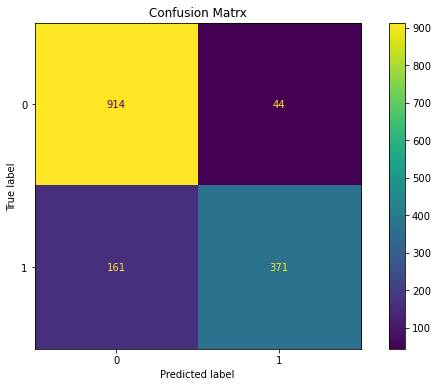

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(False)
ax.set_title('Confusion Matrx')

disp = plot_confusion_matrix(best_RF_models, X_train, y_train, ax = ax)

### Clasification report

In [12]:
print(classification_report(y_train, best_RF_models.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       958
           1       0.89      0.70      0.78       532

    accuracy                           0.86      1490
   macro avg       0.87      0.83      0.84      1490
weighted avg       0.87      0.86      0.86      1490



## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [13]:
test_id = test_df["Customer"]
test_pred = best_RF_models.predict(X_train)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission.csv", header=True, index=False)